In [2]:
!pip install --upgrade odfpy

# Chargement des bibliothèques

In [3]:
from google.colab import files
# Pour la manipulation et l'analyse des données
import pandas as pd
import numpy as np
# Pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
# Pour les opérations sur les chaînes de caractères
import re
# Pour la normalisation des données
from sklearn.preprocessing import StandardScaler
# Pour la réduction de dimensionnalité
from sklearn.decomposition import PCA
# Pour les algorithmes de clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
# Pour calculer des métriques comme le score de silhouette
from sklearn.metrics import silhouette_score
# Pour la construction de modèles de régression
from sklearn.ensemble import RandomForestRegressor
# Pour la validation croisée des modèles
from sklearn.model_selection import cross_val_score
# Pour l'analyse des règles d'association
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

**Lecture de datset**

In [4]:
# Charger les données
## en ciblant la feuille nommée 'Sheet1'
file_path = '/content/BMGs-2024.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1', header=None)


**Nettoyage initial : suppression des lignes entièrement vides**

In [5]:
# Nettoyage initial - supprimer les lignes complètement vides
df = df.dropna(how='all')

**Extraction et préparation des sous-ensembles de données (partie gauche et droite)**

In [6]:
# Extraction et renommage des colonnes de la partie gauche du tableau (colonnes 1 à 5)
partie_gauche = df.iloc[1:, 1:6].copy()  # Extraire les colonnes 1 à 5 à partir de la 2ème ligne
partie_gauche.columns = ['Alloys (composition)', 'Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax (mm)']  # Nommer les colonnes

# Extraction et renommage des colonnes de la partie droite du tableau (colonnes 7 à 11)
partie_droite = df.iloc[1:, 7:12].copy()  # Extraire les colonnes 7 à 11 à partir de la 2ème ligne
partie_droite.columns = ['Alloys', 'Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax (mm)']  # Nommer les colonnes

# Uniformisation du nom de la colonne 'Alloys' pour faciliter la fusion des deux parties
partie_gauche = partie_gauche.rename(columns={'Alloys (composition)': 'Alloys'})


**Concaténation des parties gauche et droite en un DataFrame unifié**

In [7]:
# Fusionner les deux parties du tableau (gauche et droite) en un seul DataFrame
# Cela permet de regrouper toutes les données d'alliages présentes dans le fichier
combined_df = pd.concat([partie_gauche, partie_droite], ignore_index=True)
## Affichage du DataFrame combiné pour vérifier le résultat
combined_df

,Alloys,Tg(K),Tx(K),Tl(K),Dmax (mm)
0,Ag30.8 Ca30.8 Mg23.1 Cu15.4,413,432,803,2.5
1,Ag38.4 Mg30.8 Ca30.8,394,426,805,0.5
2,Ag38.5 Ca30.8 Mg23 Cu7.7,384,416,854,2
3,Ag38.5 Mg38.5 Ca15.4 Cu7.7,405,436,842,0.5
4,Ag46.2 Ca30.7 Mg23.1,399,426,765,0.7
...,...,...,...,...,...
695,(Ti0.45 Cu0.378 Zr0.10Ni0.072)96 Sn4,666,715,1156,2
696,(Ti0.45 Cu0.378 Zr0.10 Ni0.072)94 Sn6,683,739,1169,1
697,Ti 30.42 Cu45.26 Ni8.32 Zr7.6 Hf8.4,680,729,1189,4
698,Ti 32.38 Cu42.34 Ni 9.28 Zr7.6 Hf8.4,482,722,1168,4


# **Nettoyage des données**

In [8]:
# Supprimer les lignes avec des valeurs manquantes dans les colonnes essentielles
# (Alloys, Tg, Tx, Tl) pour garantir l'intégrité des données utilisées par la suite
combined_df = combined_df.dropna(subset=['Alloys', 'Tg(K)', 'Tx(K)', 'Tl(K)'])
# Convertir les colonnes numériques en type float (au cas où elles seraient lues comme chaînes de caractères)
# 'errors="coerce"' convertit les valeurs non convertibles en NaN
numeric_cols = ['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax (mm)']
combined_df[numeric_cols] = combined_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

<ipython-input-8-8f3301dfdd36>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df[numeric_cols] = combined_df[numeric_cols].apply(pd.to_numeric, errors='coerce')


**Extraction des éléments chimiques et de leurs pourcentages à l’aide d’expressions régulières**

In [9]:
# Fonction pour extraire les éléments chimiques et leurs proportions à partir d'une chaîne de caractères représentant un alliage
def extract_elements(alloy_str):
    # Utilise une expression régulière pour capturer les couples (élément chimique, proportion)
    # Exemple : 'Zr55Cu30Ni5Al10' donne [('Zr', '55'), ('Cu', '30'), ('Ni', '5'), ('Al', '10')]
    elements = re.findall('([A-Z][a-z]*)(\d*\.?\d*)', alloy_str)
    element_dict = {}
    for elem, percent in elements:
        if percent:
            # Convertir la proportion en float si présente
            element_dict[elem] = float(percent)
        else:
            # Si aucune proportion n'est spécifiée, attribuer une valeur par défaut de 1.0
            element_dict[elem] = 1.0
    return element_dict

<>:5: DeprecationWarning: invalid escape sequence '\d'
<>:5: DeprecationWarning: invalid escape sequence '\d'
<ipython-input-9-5e9ca695385f>:5: DeprecationWarning: invalid escape sequence '\d'
  elements = re.findall('([A-Z][a-z]*)(\d*\.?\d*)', alloy_str)


**Extraction des éléments chimiques pour chaque alliage dans la colonne ‘Alloys’**

In [10]:
# Applique la fonction extract_elements à chaque entrée de la colonne 'Alloys'
# Cela transforme chaque chaîne d'alliage en un dictionnaire {élément: proportion}
# Exemple : 'Zr55Cu30Ni5Al10' → {'Zr': 55.0, 'Cu': 30.0, 'Ni': 5.0, 'Al': 10.0}
element_data = combined_df['Alloys'].apply(extract_elements)

**Création d’un DataFrame avec les éléments chimiques comme colonnes et remplacement des NaN par 0**

In [11]:
# Convertit la liste de dictionnaires (un par alliage) en un DataFrame :
# Chaque colonne représente un élément chimique, chaque ligne un alliage
elements_df = pd.DataFrame(list(element_data))

# Remplacer les valeurs NaN par 0 (indiquant l'absence d'un élément dans un alliage donné)
elements_df.fillna(0, inplace=True)

In [12]:
# Affiche la liste des éléments chimiques uniques trouvés dans tous les alliages.
# Ces éléments correspondent aux noms de colonnes du DataFrame `elements_df`,
# qui contient les proportions de chaque élément chimique pour chaque alliage.
print("\nÉléments chimiques extraits :", elements_df.columns.tolist())


Éléments chimiques extraits : ['Ag', 'Ca', 'Mg', 'Cu', 'Au', 'Si', 'Pd', 'Nd', 'Al', 'Ni', 'Fe', 'Zn', 'Ce', 'Ga', 'Nb', 'La', 'Co', 'B', 'Ta', 'Cr', 'C', 'Mo', 'Zr', 'Ti', 'Hf', 'In', 'Y', 'Sn', 'P', 'W', 'Er', 'Mn', 'L', 'Dy', 'Tb', 'Gd', 'Tm', 'G', 'Ho', 'Pr', 'S', 'Be', 'Sc', 'Sm', 'V', 'Mm']


Concaténation des données numériques et des compositions chimiques extraites

In [13]:
# Ajoute les colonnes correspondant aux éléments chimiques (extraites dans `elements_df`)
# au DataFrame principal `combined_df`, qui contient déjà les variables numériques telles que
# 'Tg(K)', 'Tx(K)', 'Tl(K)', et 'Dmax (mm)'.
# Cela permet de combiner à la fois les propriétés physiques et la composition chimique
# dans un seul tableau pour faciliter l'analyse statistique et le machine learning.
combined_df = pd.concat([combined_df[numeric_cols] , elements_df], axis=1)

# **Affichage du DataFrame final combiné**

In [14]:
combined_df

,Tg(K),Tx(K),Tl(K),Dmax (mm),Ag,Ca,Mg,Cu,Au,Si,...,Tm,G,Ho,Pr,S,Be,Sc,Sm,V,Mm
0,413.0,432.0,803.0,2.5,30.8,30.8,23.1,15.40,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,394.0,426.0,805.0,0.5,38.4,30.8,30.8,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,384.0,416.0,854.0,2.0,38.5,30.8,23.0,7.70,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,405.0,436.0,842.0,0.5,38.5,15.4,38.5,7.70,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,399.0,426.0,765.0,0.7,46.2,30.7,23.1,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,680.0,729.0,1189.0,4.0,0.0,0.0,0.0,40.88,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
698,482.0,722.0,1168.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699,679.0,716.0,1188.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,NaN,NaN,0.0,0.0,0.0,18.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Supposons que df est votre DataFrame
combined_df.to_csv('New-BMGs-2024.csv', index=False)

# Télécharger le fichier sur votre ordinateur
#files.download('New-BMGs-2024.csv')

In [16]:
# Afficher les premières lignes du DataFrame
print("DataFrame combiné - premières lignes:")
print(combined_df.head()) # .head() affiche les 5 premières lignes par défaut

# Afficher les informations générales sur le DataFrame,
# notamment le nombre de lignes, le nombre de colonnes, les types de données,
# et le nombre de valeurs non nulles pour chaque colonne
print("\nInformations sur le dataset combiné:")
print(combined_df.info())

# Afficher les statistiques descriptives pour les colonnes numériques
# Cela inclut la moyenne, l'écart-type, les quartiles, le minimum et le maximum
print("\nStatistiques descriptives:")
print(combined_df[numeric_cols].describe())  # .describe() génère ces statistiques uniquement pour les colonnes numériques

DataFrame combiné - premières lignes:
   Tg(K)  Tx(K)  Tl(K)  Dmax (mm)    Ag    Ca    Mg    Cu   Au   Si  ...   Tm  \
0  413.0  432.0  803.0        2.5  30.8  30.8  23.1  15.4  0.0  0.0  ...  0.0   
1  394.0  426.0  805.0        0.5  38.4  30.8  30.8   0.0  0.0  0.0  ...  0.0   
2  384.0  416.0  854.0        2.0  38.5  30.8  23.0   7.7  0.0  0.0  ...  0.0   
3  405.0  436.0  842.0        0.5  38.5  15.4  38.5   7.7  0.0  0.0  ...  0.0   
4  399.0  426.0  765.0        0.7  46.2  30.7  23.1   0.0  0.0  0.0  ...  0.0   

     G   Ho   Pr    S   Be   Sc   Sm    V   Mm  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 50 columns]

Informations sur le dataset combiné:
<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 630
Data columns (total 50 columns):
 #   Column     Non-

# **Gestion des valeurs manquantes**

---



In [17]:
# Afficher le nombre de valeurs manquantes (NaN) pour chaque colonne du DataFrame
# combined_df.isnull() crée un DataFrame de booléens où True indique une valeur manquante
# .sum() additionne ces True (considérés comme 1) par colonne, donnant le total des valeurs manquantes par colonne
print("\nValeurs manquantes par colonne:")
print(combined_df.isnull().sum())


Valeurs manquantes par colonne:
Tg(K)        2
Tx(K)        2
Tl(K)        2
Dmax (mm)    2
Ag           2
Ca           2
Mg           2
Cu           2
Au           2
Si           2
Pd           2
Nd           2
Al           2
Ni           2
Fe           2
Zn           2
Ce           2
Ga           2
Nb           2
La           2
Co           2
B            2
Ta           2
Cr           2
C            2
Mo           2
Zr           2
Ti           2
Hf           2
In           2
Y            2
Sn           2
P            2
W            2
Er           2
Mn           2
L            2
Dy           2
Tb           2
Gd           2
Tm           2
G            2
Ho           2
Pr           2
S            2
Be           2
Sc           2
Sm           2
V            2
Mm           2
dtype: int64


In [18]:
# Remplacer les valeurs manquantes (NaN) dans combined_df par la moyenne de chaque colonne numérique
# combined_df.mean() calcule la moyenne de chaque colonne numérique
# fillna() remplace les NaN par ces moyennes correspondantes
combined_df = combined_df.fillna(combined_df.mean())
# Vérifier s'il reste des valeurs manquantes après ce remplacement
# isnull().sum() compte les NaN par colonne, ici on s'attend à ce que ce soit zéro
combined_df.isnull().sum()

,0
Tg(K),0
Tx(K),0
Tl(K),0
Dmax (mm),0
Ag,0
Ca,0
Mg,0
Cu,0
Au,0
Si,0


# **Gestion des valeurs abberantes**

In [19]:
import pandas as pd
import numpy as np

# Étape 1 : Fonction pour détecter et traiter les valeurs aberrantes (outliers)
def treat_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:  # Appliquer seulement aux colonnes numériques
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculer la médiane de la colonne (valeur de remplacement)
        median = df[column].median()
        # Remplacer les valeurs inférieures à la borne inférieure par la médiane
        df[column] = np.where(df[column] < lower_bound, median, df[column])
        # Remplacer les valeurs supérieures à la borne supérieure par la médiane
        df[column] = np.where(df[column] > upper_bound, median, df[column])
    return df

# Étape 2 : Appliquer cette fonction sur le DataFrame combined_df
combined_df = treat_outliers(combined_df)

# Étape 3 : Vérifier que les valeurs extrêmes ont été traitées
print("\nValeurs extrêmes traitées. Aperçu du DataFrame nettoyé :")
combined_df.describe()



Valeurs extrêmes traitées. Aperçu du DataFrame nettoyé :


,Tg(K),Tx(K),Tl(K),Dmax (mm),Ag,Ca,Mg,Cu,Au,Si,...,Tm,G,Ho,Pr,S,Be,Sc,Sm,V,Mm
count,700.000000,700.000000,700.000000,700.000000,700.0,700.0,700.000000,700.000000,700.0,700.0,...,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0
mean,613.895272,664.923496,1065.123926,3.880192,0.0,0.0,0.191183,17.083212,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,180.051978,187.643970,277.978132,2.873758,0.0,0.0,1.302962,19.471477,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,341.000000,377.000000,630.000000,0.100000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,419.750000,470.000000,773.750000,2.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,670.000000,731.000000,1145.000000,3.000000,0.0,0.0,0.000000,7.700000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,747.000000,799.250000,1273.500000,5.000000,0.0,0.0,0.000000,34.250000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,959.000000,1019.000000,1559.000000,12.000000,0.0,0.0,11.000000,83.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


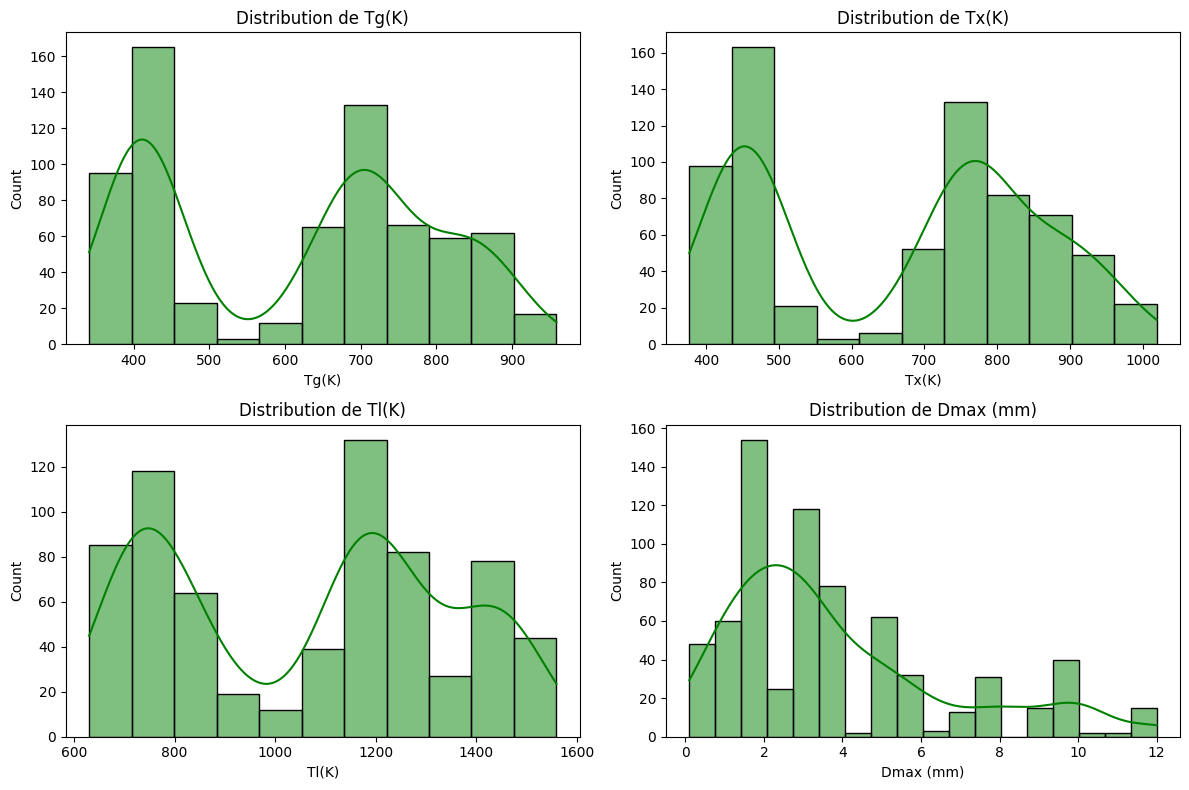

In [44]:
# Définir la taille globale de la figure (largeur = 12, hauteur = 8)
plt.figure(figsize=(12, 8))

# Parcourir chaque colonne numérique avec un index commençant à 1
for i, col in enumerate(numeric_cols, 1):
    # Créer un sous-graphique (subplot) dans une grille de 2 lignes × 2 colonnes à la position i
    plt.subplot(2, 2, i)

    # Tracer l'histogramme de la colonne actuelle avec une courbe de densité (KDE)
    # Couleur de l'histogramme définie sur "green"
    sns.histplot(combined_df[col], kde=True, color="green")

    # Ajouter un titre personnalisé au sous-graphique
    plt.title(f'Distribution de {col}')

# Ajuster automatiquement les espacements entre les sous-graphes pour éviter les chevauchements
plt.tight_layout()

# Afficher la figure contenant tous les sous-graphes
plt.show()


# **corrélations entre variables numériques**


Matrice de corrélation:
              Tg(K)     Tx(K)     Tl(K)  Dmax (mm)
Tg(K)      1.000000  0.993263  0.977811  -0.103536
Tx(K)      0.993263  1.000000  0.971294  -0.071356
Tl(K)      0.977811  0.971294  1.000000  -0.149572
Dmax (mm) -0.103536 -0.071356 -0.149572   1.000000


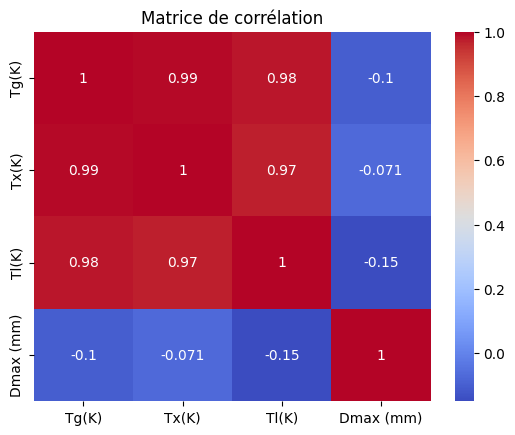

In [21]:
# Calculer la matrice de corrélation pour les colonnes numériques du DataFrame
# La corrélation mesure la force et la direction de la relation linéaire entre deux variables
print("\nMatrice de corrélation:")
corr_matrix = combined_df[numeric_cols].corr() # .corr() calcule le coefficient de corrélation de Pearson
print(corr_matrix)

# Visualiser cette matrice avec une heatmap (carte de chaleur)
# annot=True : affiche les valeurs numériques sur la heatmap
# cmap='coolwarm' : choix d'une palette de couleurs allant du bleu (corr négative) au rouge (corr positive)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

# **la normalisation**




In [22]:
# Étape 1 : Appliquer la normalisation Min-Max sur toutes les colonnes du DataFrame
# MinMaxScaler transforme les données pour que chaque valeur soit comprise entre 0 et 1
scaler = MinMaxScaler() # Initialisation du scaler Min-Max
normalized_data = scaler.fit_transform(combined_df)

# Conversion du tableau numpy résultant en DataFrame pandas pour faciliter la manipulation
# On conserve les mêmes noms de colonnes que dans combined_df
normalized_df = pd.DataFrame(normalized_data, columns=combined_df.columns)
# Affichage du DataFrame normalisé
normalized_df

,Tg(K),Tx(K),Tl(K),Dmax (mm),Ag,Ca,Mg,Cu,Au,Si,...,Tm,G,Ho,Pr,S,Be,Sc,Sm,V,Mm
0,0.116505,0.085670,0.186222,0.201681,0.0,0.0,0.000000,0.185542,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.085761,0.076324,0.188375,0.033613,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.069579,0.060748,0.241119,0.159664,0.0,0.0,0.000000,0.092771,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.103560,0.091900,0.228202,0.033613,0.0,0.0,0.000000,0.092771,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.093851,0.076324,0.145318,0.050420,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.548544,0.548287,0.601722,0.327731,0.0,0.0,0.000000,0.492530,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,0.228155,0.537383,0.579117,0.327731,0.0,0.0,0.874017,0.205822,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,0.546926,0.528037,0.600646,0.159664,0.0,0.0,0.874017,0.205822,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
698,0.441578,0.448479,0.468379,0.430028,0.0,0.0,0.000000,0.216867,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA avec 2 composantes principales

In [23]:
# Étape 2 : Appliquer l’ACP (Analyse en Composantes Principales) pour réduire la dimensionnalité à 2 composantes
pca = PCA(n_components=2) # Initialisation du modèle PCA avec 2 composantes principales
pca_result = pca.fit_transform(normalized_df)
# fit_transform calcule les composantes principales et projette les données dessus

# Créer un nouveau DataFrame avec les deux premières composantes principales nommées "PCA1" et "PCA2"
pca_df = pd.DataFrame(data=pca_result, columns=["PCA1", "PCA2"])
# Afficher le DataFrame résultant avec les coordonnées dans l’espace réduit à 2 dimensions
pca_df

,PCA1,PCA2
0,-0.543534,-0.220702
1,-0.541782,-0.341253
2,-0.543768,-0.272506
3,-0.506023,-0.303960
4,-0.563044,-0.335182
...,...,...
695,0.171149,-0.066969
696,-0.033183,0.033034
697,0.164220,-0.016407
698,-0.013650,-0.165218


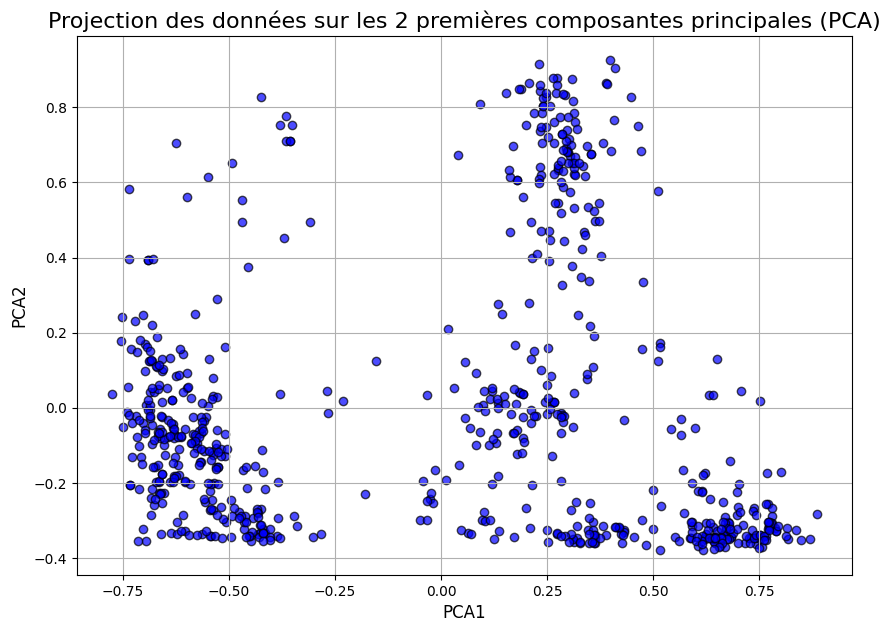

In [24]:
# Étape 3 : Visualisation de la projection des données sur les 2 premières composantes principales
plt.figure(figsize=(10, 7)) # Définir la taille de la figure
# Tracer un nuage de points avec PCA1 en abscisse et PCA2 en ordonnée
# c="blue" : couleur des points
# alpha=0.7 : transparence des points pour mieux visualiser les zones denses
# edgecolor="k" : bord noir autour des points pour mieux les distinguer
plt.scatter(pca_df["PCA1"], pca_df["PCA2"], c="blue", alpha=0.7, edgecolor="k")
# Ajouter un titre à la figure avec une taille de police plus grande
plt.title("Projection des données sur les 2 premières composantes principales (PCA)", fontsize=16)
# Étiquettes des axes X et Y avec une taille de police adaptée
plt.xlabel("PCA1", fontsize=12)
plt.ylabel("PCA2", fontsize=12)
# Afficher une grille pour faciliter la lecture des points sur le graphique
plt.grid(True)
# Afficher la figure complète
plt.show()

# **la méthode Elbow**

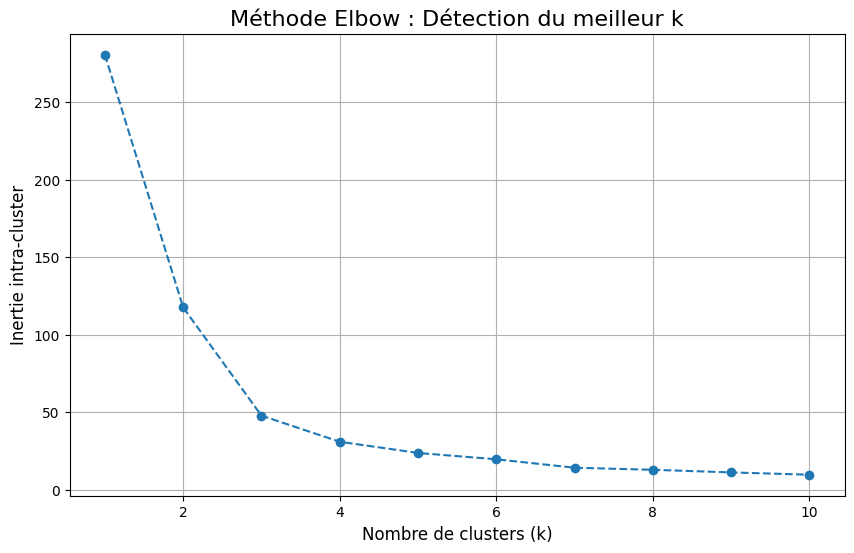

In [25]:
# Initialiser une liste pour stocker les valeurs d'inertie pour chaque nombre de clusters k
inertia = []
# Définir la plage des valeurs de k à tester, ici de 1 à 10 clusters
k_range = range(1, 11)  # Tester k de 1 à 10
# Boucle pour calculer l'inertie (somme des distances au carré aux centres des clusters)
# pour chaque valeur de k dans k_range
for k in k_range:
    # Initialiser le modèle KMeans avec k clusters et une graine fixe pour la reproductibilité
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Appliquer KMeans sur les données réduites par PCA (2 dimensions)
    kmeans.fit(pca_df)
    # Ajouter l'inertie (critère d'évaluation) dans la liste
    inertia.append(kmeans.inertia_)

# Étape 3 : Visualisation de la courbe Elbow pour choisir le nombre optimal de clusters
plt.figure(figsize=(10, 6))
# Tracer la courbe de l'inertie en fonction du nombre de clusters k
plt.plot(k_range, inertia, marker='o', linestyle='--')
# Ajouter un titre explicite
plt.title("Méthode Elbow : Détection du meilleur k", fontsize=16)
# Légendes des axes
plt.xlabel("Nombre de clusters (k)", fontsize=12)
plt.ylabel("Inertie intra-cluster", fontsize=12)
# Afficher une grille pour faciliter l'interprétation
plt.grid(True)
# Afficher le graphique
plt.show()

# K-means

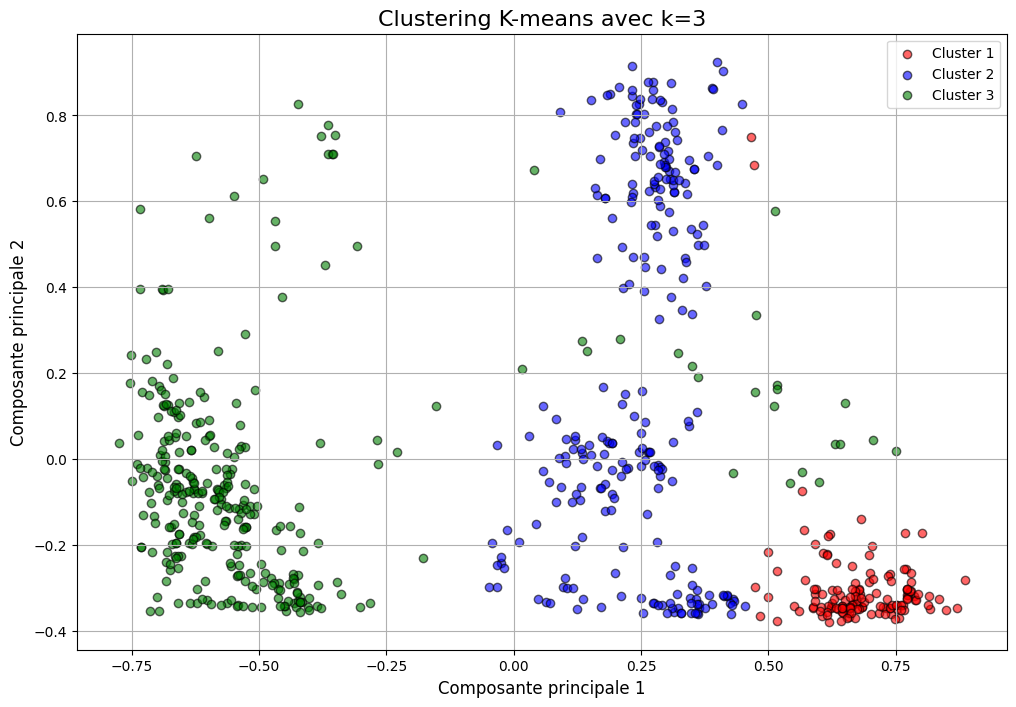

In [42]:
# Application de K-means avec le k optimal
best_k = 3  # Remplacer par le k optimal déterminé visuellement
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(pca_df.iloc[:, :-1])  # Exclure la colonne Cluster si elle existe déjà

# Ajouter les clusters au DataFrame
pca_df["Cluster"] = clusters

# Visualisation des clusters
plt.figure(figsize=(12, 8))

# Liste de couleurs pour les clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'pink']
for cluster in range(best_k):
    cluster_points = pca_df[pca_df["Cluster"] == cluster]
    plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1],
                color=colors[cluster], label=f"Cluster {cluster + 1}", alpha=0.6, edgecolor="k")

# Personnalisation du graphique
plt.title(f"Clustering K-means avec k={best_k}", fontsize=16)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True)
plt.show()


# DBSCAN

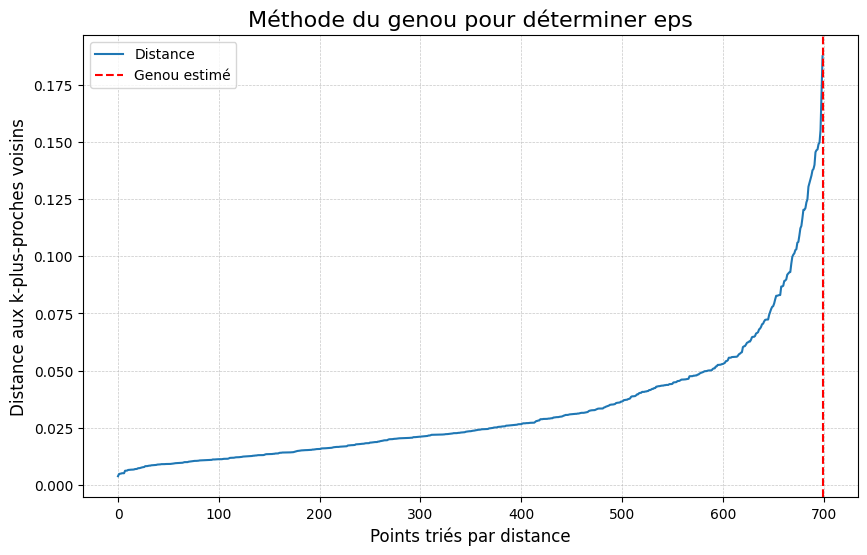

Meilleur eps : 0.1
Meilleur min_samples : 8
Meilleur score silhouette : 0.5910239633833895


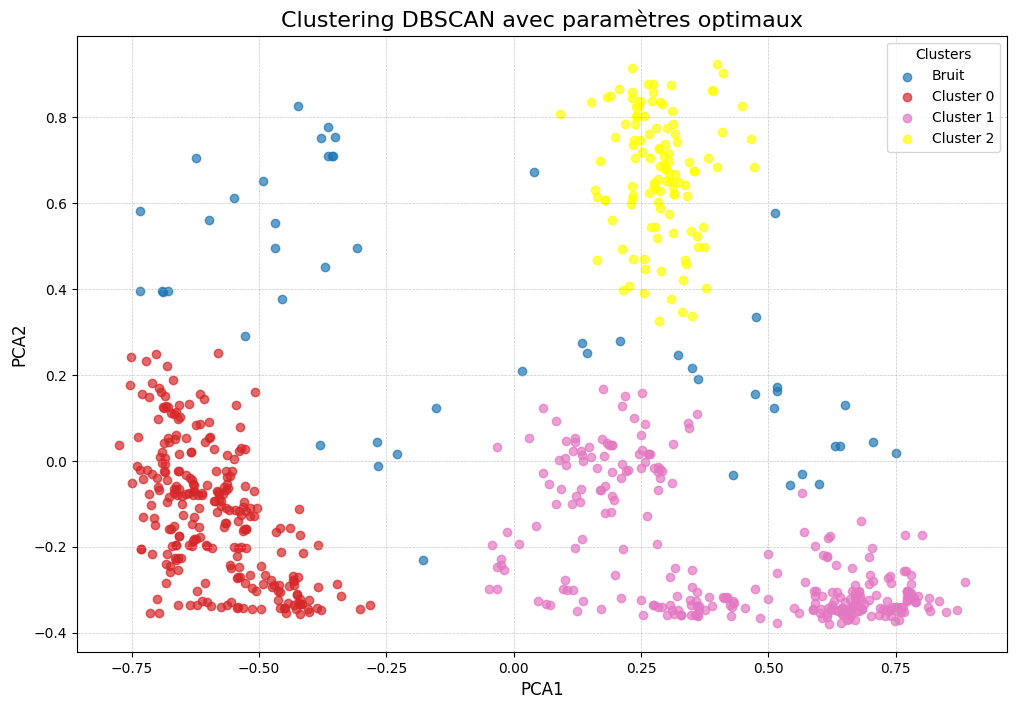


Résumé des clusters détectés par DBSCAN :
 1    272
 0    260
 2    117
-1     51
Name: count, dtype: int64


In [27]:

# Étape 1 : Méthode des k-plus-proches voisins pour estimer un intervalle de eps
k = 4
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(pca_df[['PCA1', 'PCA2']])
distances, indices = nbrs.kneighbors(pca_df[['PCA1', 'PCA2']])

# Trier les distances pour repérer le genou
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances, label="Distance")
plt.axvline(x=np.argmax(distances), color="red", linestyle="--", label="Genou estimé")
plt.title("Méthode du genou pour déterminer eps", fontsize=16)
plt.xlabel("Points triés par distance", fontsize=12)
plt.ylabel("Distance aux k-plus-proches voisins", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

# Étape 2 : Optimisation dynamique des paramètres eps et min_samples
best_eps = None
best_min_samples = None
best_silhouette = -1
best_clusters = None

eps_values = np.linspace(0.1, 1.0, 10)  # Ajustez les intervalles si nécessaire
min_samples_values = range(3, 10)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(pca_df[['PCA1', 'PCA2']])

        if len(set(clusters)) > 1 and -1 in clusters:  # Vérifier des clusters valides
            silhouette_avg = silhouette_score(pca_df[['PCA1', 'PCA2']], clusters)
            if silhouette_avg > best_silhouette:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette = silhouette_avg
                best_clusters = clusters

# Étape 3 : Résultats optimaux
print(f"Meilleur eps : {best_eps}")
print(f"Meilleur min_samples : {best_min_samples}")
print(f"Meilleur score silhouette : {best_silhouette}")

# Ajouter les clusters au DataFrame
pca_df['Cluster_DBSCAN'] = best_clusters

# Étape 4 : Visualisation avec Cluster 2 en jaune
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(best_clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    if cluster == 2:  # Changer la couleur de Cluster 2 en jaune
        color = "yellow"
    cluster_points = pca_df[pca_df['Cluster_DBSCAN'] == cluster]
    label = f"Cluster {cluster}" if cluster != -1 else "Bruit"
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], color=color, label=label, alpha=0.7)

plt.title('Clustering DBSCAN avec paramètres optimaux', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(fontsize=10, title="Clusters")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

# Étape 5 : Résumé des clusters détectés
cluster_counts = pd.Series(best_clusters).value_counts()
print("\nRésumé des clusters détectés par DBSCAN :")
print(cluster_counts)



# Clustering Hiérarchique Agglomératif (AHC)

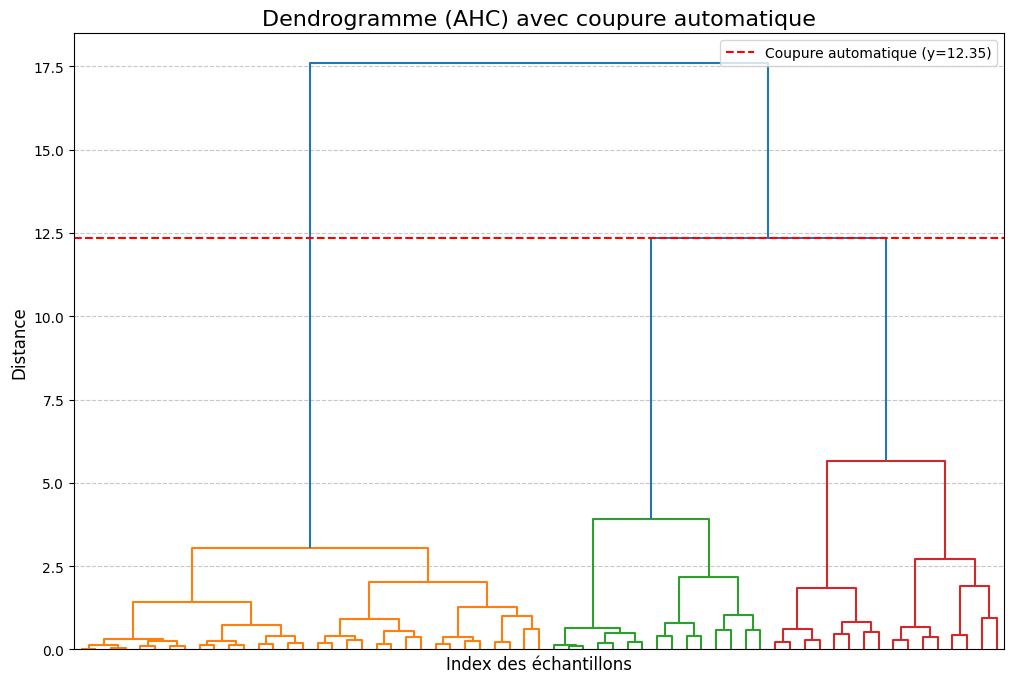

In [28]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

# Calcul de la matrice de liaison
linkage_matrix = linkage(pca_df[['PCA1', 'PCA2']], method='ward')

# Calcul du seuil automatique (premier grand saut)
distances = linkage_matrix[:, 2]
diff_distances = np.diff(distances)
threshold_index = np.argmax(diff_distances) + 1
threshold = distances[threshold_index]

# Affichage du dendrogramme avec coupure automatique
plt.figure(figsize=(12, 8))
dendro = dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=threshold, no_labels=True)
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Coupure automatique (y={threshold:.2f})")
plt.title('Dendrogramme (AHC) avec coupure automatique', fontsize=16)
plt.xlabel('Index des échantillons', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<ipython-input-29-fff3c83098f4>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', n_clusters)


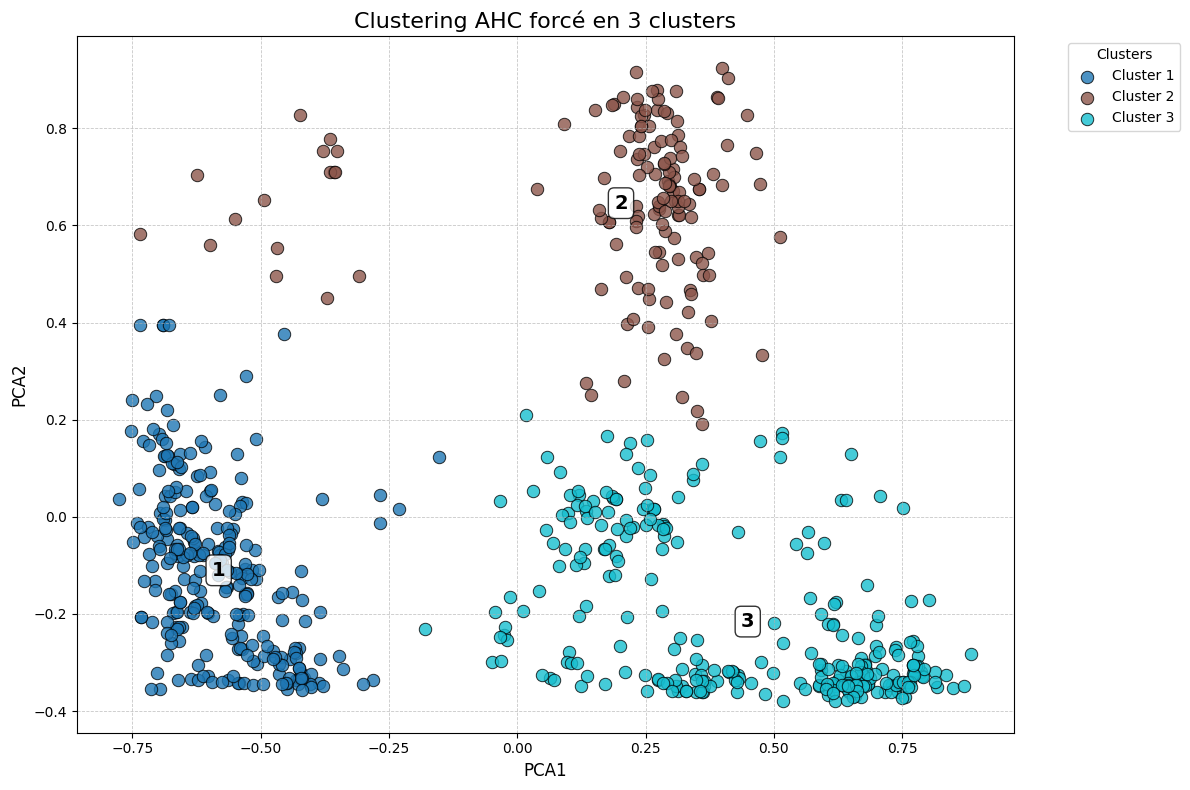


Résumé des clusters forcés à 3 par AHC (taille des clusters) :
1    271
2    142
3    287
Name: count, dtype: int64


In [29]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import numpy as np
from matplotlib import cm
import pandas as pd

# Forcer la création de 3 clusters
clusters_ahc = fcluster(linkage_matrix, t=3, criterion='maxclust')

# Ajouter la colonne des clusters au DataFrame
pca_df['Cluster_AHC'] = clusters_ahc

# Visualisation améliorée des clusters forcés en 3
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(clusters_ahc)
n_clusters = len(unique_clusters)
colors = cm.get_cmap('tab10', n_clusters)

for idx, cluster in enumerate(unique_clusters):
    cluster_points = pca_df[pca_df['Cluster_AHC'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'],
                color=colors(idx), label=f"Cluster {cluster}", alpha=0.8,
                edgecolor='k', linewidth=0.7, s=80)

   # Calculer et afficher le centroïde du cluster avec un texte encadré
    centroid_x = cluster_points['PCA1'].mean()
    centroid_y = cluster_points['PCA2'].mean()
    plt.text(centroid_x, centroid_y, str(cluster), fontsize=14, fontweight='bold',
             color='black', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3'))
# Ajouter titre, légendes des axes et légende des clusters
plt.title('Clustering AHC forcé en 3 clusters', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(fontsize=10, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
# Grille avec style léger et ajustement du layout pour éviter chevauchement
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
# Afficher la figure
plt.show()

# Résumé du nombre d’éléments par cluster
cluster_counts = pd.Series(clusters_ahc).value_counts()
print("\nRésumé des clusters forcés à 3 par AHC (taille des clusters) :")
print(cluster_counts.sort_index())


# **le score de silhouette**

In [36]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Supposons que vous avez déjà préparé vos données dans 'X'
# Remplacer les valeurs manquantes et normaliser les données si nécessaire
X = combined_df[numeric_cols].fillna(combined_df.mean()).values

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score for K-means: {kmeans_silhouette:.4f}")



# 3. Agglomerative Hierarchical Clustering (AHC)
ahc = AgglomerativeClustering(n_clusters=3)
ahc_labels = ahc.fit_predict(X_scaled)
ahc_silhouette = silhouette_score(X_scaled, ahc_labels)
print(f"Silhouette Score for AHC: {ahc_silhouette:.4f}")

# Visualisation des scores
import matplotlib.pyplot as plt

methods = ['K-means', 'AHC']
scores = [kmeans_silhouette, dbscan_silhouette if 'dbscan_silhouette' in locals() else 0, ahc_silhouette]



Silhouette Score for K-means: 0.4587
Silhouette Score for AHC: 0.5488


Connaissance cachée sur les donnes

In [31]:
X_dmax = scaler.fit_transform(combined_df[['Dmax (mm)']])


# **Préparation et nettoyage des données puis calcul de la variable Trg**

In [32]:
# Charger le fichier CSV en spécifiant que les noms des colonnes sont à la première ligne (header=0)
df = pd.read_csv("/content/New-BMGs-2024.csv", header=0)

# Vérifie les noms des colonnes
print(df.columns.tolist())
# Nettoyer les noms de colonnes en supprimant les espaces en début et fin
df.columns = df.columns.str.strip()

# Supprimer les lignes où la colonne 'Dmax (mm)' contient des valeurs manquantes (NaN)
df = df.dropna(subset=['Dmax (mm)'])
# Supprimer les lignes où 'Tl(K)' est zéro pour éviter les divisions par zéro lors du calcul de Trg
df = df[df['Tl(K)'] != 0]

# Calculer la variable Trg comme le rapport Tg(K) / Tl(K)
df['Trg'] = df['Tg(K)'] / df['Tl(K)']



['Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax (mm)', 'Ag', 'Ca', 'Mg', 'Cu', 'Au', 'Si', 'Pd', 'Nd', 'Al', 'Ni', 'Fe', 'Zn', 'Ce', 'Ga', 'Nb', 'La', 'Co', 'B', 'Ta', 'Cr', 'C', 'Mo', 'Zr', 'Ti', 'Hf', 'In', 'Y', 'Sn', 'P', 'W', 'Er', 'Mn', 'L', 'Dy', 'Tb', 'Gd', 'Tm', 'G', 'Ho', 'Pr', 'S', 'Be', 'Sc', 'Sm', 'V', 'Mm']


**Application et visualisation de différents algorithmes de clustering sur la variable Dmax**

In [33]:
# Import des méthodes de clustering et du scaler pour la normalisation, plus Plotly pour la visualisation
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Standardiser la variable 'Dmax (mm)' : moyenne = 0, écart-type = 1
scaler = StandardScaler()
X_dmax = scaler.fit_transform(df[['Dmax (mm)']])

# Clustering KMeans avec 3 clusters sur les données normalisées de Dmax
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_dmax)
df['KMeans'] = kmeans.labels_

# Clustering DBSCAN (basé sur densité) avec eps=0.5 et min_samples=5
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_dmax)
df['DBSCAN'] = dbscan.labels_

# Clustering hiérarchique agglomératif avec 3 clusters
hierarchical = AgglomerativeClustering(n_clusters=3).fit(X_dmax)
df['Hierarchical'] = hierarchical.labels_  # Ajouter labels au DataFrame

# Visualisation interactive avec Plotly Express :
# Nuage de points Dmax (mm) vs Trg, coloré par clusters KMeans
fig = px.scatter(df, x='Dmax (mm)', y='Trg', color='KMeans', title='Clustering K-Means sur Dmax')
fig.show()


**Calcul d’un score global composite et sélection des meilleurs alliages**

In [34]:
# Supprimer les lignes où la somme des températures Tg(K) + Tl(K) est nulle ou manquante
# On élimine ces lignes car la division par cette somme poserait problème (division par zéro ou NaN)
df = df[(df['Tg(K)'] + df['Tl(K)']).notna() & ((df['Tg(K)'] + df['Tl(K)']) != 0)]

# Calculer la variable 'gamma' comme le ratio Tx(K) / (Tg(K) + Tl(K))
df['gamma'] = df['Tx(K)'] / (df['Tg(K)'] + df['Tl(K)'])
# Normalisation simple des colonnes Dmax (mm), Trg et gamma par leur maximum respectif
# Puis calculer la moyenne de ces valeurs normalisées pour chaque ligne
df['score_global'] = df[['Dmax (mm)', 'Trg', 'gamma']].apply(lambda x: x / x.max(), axis=0).mean(axis=1)

# Sélectionner les 10 meilleures entrées selon le score global décroissant
top_alliages = df.sort_values('score_global', ascending=False).head(10)
# Afficher les colonnes d’intérêt pour ces meilleurs alliages
print(top_alliages[['Dmax (mm)', 'Trg', 'gamma', 'score_global']])



     Dmax (mm)       Trg     gamma  score_global
621       72.0  0.690191  0.464260      1.000000
681       50.0  0.642931  0.422111      0.845060
288       35.0  0.617360  0.445235      0.779870
684       28.0  0.638614  0.441692      0.755183
633       30.0  0.613818  0.432492      0.745861
294       30.0  0.613158  0.431756      0.745014
291       30.0  0.613158  0.431756      0.745014
336       25.0  0.623791  0.452650      0.742003
638       25.0  0.607427  0.438394      0.723864
282       25.0  0.614500  0.426616      0.718823


Régression Random Forest pour prédire Dmax à partir des clusters et de la composition des alliages

**Analyse des corrélations entre éléments chimiques et propriétés physiques des alliages**

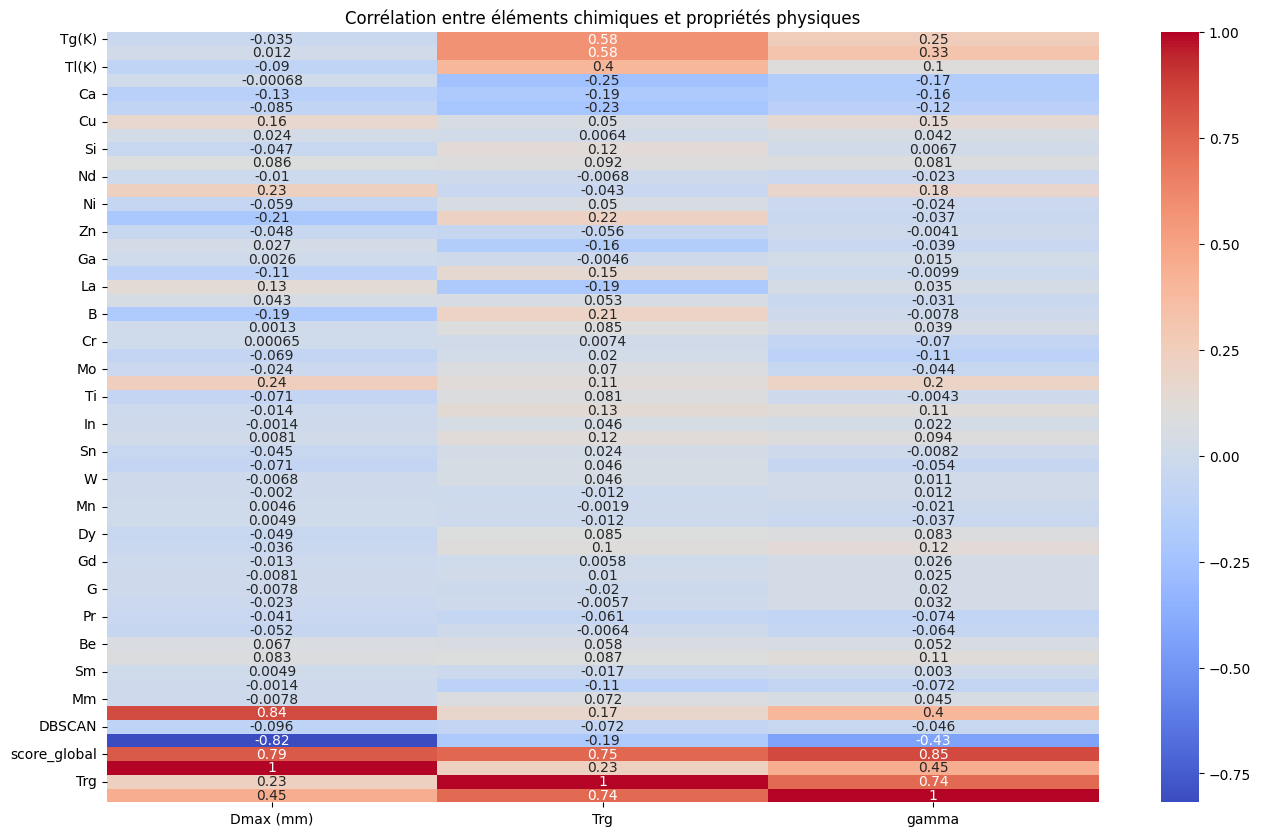

In [40]:
# Liste des colonnes représentant les propriétés physiques
variables_physiques = ['Dmax (mm)', 'Trg', 'gamma']

# Identifier les colonnes restantes comme éléments chimiques
# On prend toutes les colonnes sauf celles listées dans variables_physiques
composition_elements = [col for col in df.columns if col not in variables_physiques]
# Calculer la matrice de corrélation entre les éléments chimiques et les propriétés physiques
# On sélectionne uniquement les colonnes d'intérêt
correlation = df[composition_elements + variables_physiques].corr()
# Définir la taille de la figure pour une meilleure lisibilité
plt.figure(figsize=(16, 10))
# Afficher la heatmap de corrélation
# On ne montre que la corrélation des éléments chimiques avec les variables physiques (colonnes variables_physiques)
sns.heatmap(correlation[variables_physiques], annot=True, cmap='coolwarm')

# Ajouter un titre explicite
plt.title("Corrélation entre éléments chimiques et propriétés physiques")
# Afficher la figure
plt.show()


**Analyse des moyennes des critères (Trg, gamma, score_global) selon les plages de Dmax**

<ipython-input-41-2124a3a98630>:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



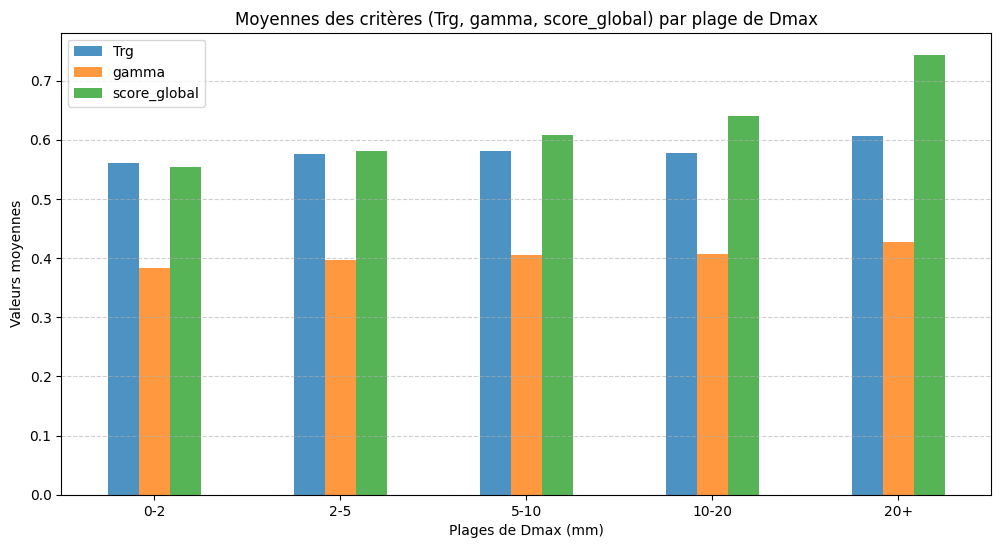

In [41]:
# Créer des plages (bins) pour la variable 'Dmax (mm)' selon des intervalles définis
# bins contient les bornes des intervalles, ici ajustables selon le besoin
bins = [0, 2, 5, 10, 20, df['Dmax (mm)'].max()]
# labels correspond aux noms que l'on donne à chaque intervalle pour plus de lisibilité
labels = ['0-2', '2-5', '5-10', '10-20', '20+']
# Découper la colonne 'Dmax (mm)' en intervalles catégoriels selon bins et labels
# include_lowest=True inclut la borne inférieure dans la première catégorie
df['Dmax_range'] = pd.cut(df['Dmax (mm)'], bins=bins, labels=labels, include_lowest=True)

# Calcul des moyennes des indicateurs pour chaque plage
mean_values = df.groupby('Dmax_range')[['Trg', 'gamma', 'score_global']].mean()

# Affichage en barres
mean_values.plot(kind='bar', figsize=(12, 6), alpha=0.8)
# Ajouter un titre et des labels aux axes pour clarifier le graphique
plt.title("Moyennes des critères (Trg, gamma, score_global) par plage de Dmax")
plt.xlabel("Plages de Dmax (mm)")
plt.ylabel("Valeurs moyennes")
# Rotation des labels en abscisse pour une meilleure lisibilité (ici aucun angle)
plt.xticks(rotation=0)
# Ajouter une grille horizontale discrète pour mieux lire les valeurs
plt.grid(axis='y', linestyle='--', alpha=0.6)
# Afficher la figure
plt.show()


# **Conclusion**
L’analyse révèle une relation claire entre la dimension critique Dmax et les indicateurs thermodynamiques Trg et gamma :

plus Dmax est élevé, plus Trg et gamma augmentent, ce qui indique une meilleure aptitude à la formation du verre amorphe (GFA).

Cette tendance montre que les alliages avec de fortes valeurs de Dmax bénéficient de conditions thermodynamiques et cinétiques optimales:

 -Meilleure stabilité du liquide surfondu,

 -Moindre tendance à la cristallisation,

-Plus grande facilité de vitrification.

Le calcul d’un score global combinant Dmax, Trg et gamma permet de classer efficacement les alliages et d’identifier les meilleurs candidats. Les méthodes de clustering ont également permis de regrouper les alliages selon leur comportement, ouvrant la voie à une conception plus ciblée de nouveaux matériaux.
